#Open Library Analysis - Big Data Computing Project
####Graph's Connected Components vs. k-means Clusters

In this notebook we analyse Open Library's data dumps freely downloadable from their website. https://openlibrary.org/developers/dumps
Books' data is probided in JSON records, which we preprocessed so as to keep only relevant information into a .csv file.

In the following we will clean the dataset and extract relevant features.

We use the resulting dataset to create a graph representing books affinity (i.e. nodes represent books and an edge connects two nodes only if their similarity is above a certain threshold). We are then interested in finding then connected components of such graph. 

Moreover, we will perform k-means clustering and compare, in terms of Silhouette Coefficient, the resulting clusters with the connected components of the aforementioned graph.

##Libraries

In [0]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *

from pyspark.sql.functions import *

from pyspark import SparkContext, SparkConf
from time import process_time

### Dependencies

In [0]:
spark.sparkContext.setCheckpointDir('/databricks/driver/checkpoints')

##Data Aquisition

It is possible to download the full dataset (22.589.356 entries) or only the first 50000 entries

short dataset: 50000 entries

In [0]:
%sh wget -P /tmp https://raw.githubusercontent.com/attennig/BDC_datasets/main/books_short.csv

In [0]:
dbutils.fs.mv("file:/tmp/books_short.csv", "dbfs:/bdc-2020-21/datasets/books_short.csv")

long dataset: 22.589.356 entries

In [0]:
%sh wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G" -O /tmp/books_long.csv.bz2 && rm -rf /tmp/cookies.txt

--2021-07-07 16:44:52-- https://docs.google.com/uc?export=download&confirm=xYjV&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G
Resolving docs.google.com (docs.google.com)... 142.251.33.78, 2607:f8b0:400a:807::200e
Connecting to docs.google.com (docs.google.com)|142.251.33.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/6lfa138t64i45uh23r3jv2tou86fbn44/1m3lda9fkdoen8dbl22jj5c92r0pg2nh/1625676225000/04018998011970375350/03286386788565222246Z/1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G?e=download [following]
--2021-07-07 16:44:52-- https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/6lfa138t64i45uh23r3jv2tou86fbn44/1m3lda9fkdoen8dbl22jj5c92r0pg2nh/1625676225000/04018998011970375350/03286386788565222246Z/1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G?e=download
Resolving doc-0o-5c-docs.googleusercontent.com (doc-0o-5c-docs.googleusercontent.com)... 142.250.217.65, 2607:f8b0:400a:80a::2001
Connecting to doc-0o-5c-docs.googleusercontent.com (doc-0o-5c-docs.googleusercontent.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://docs.google.com/nonceSigner?nonce=fadfgi6khf7iu&continue=https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/6lfa138t64i45uh23r3jv2tou86fbn44/1m3lda9fkdoen8dbl22jj5c92r0pg2nh/1625676225000/04018998011970375350/03286386788565222246Z/1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G?e%3Ddownload&hash=c6sudt5fdibd2d8022hqd7uiis6004du [following]
--2021-07-07 16:44:53-- https://docs.google.com/nonceSigner?nonce=fadfgi6khf7iu&continue=https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/6lfa138t64i45uh23r3jv2tou86fbn44/1m3lda9fkdoen8dbl22jj5c92r0pg2nh/1625676225000/04018998011970375350/03286386788565222246Z/1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G?e%3Ddownload&hash=c6sudt5fdibd2d8022hqd7uiis6004du
Connecting to docs.google.com (docs.google.com)|142.251.33.78|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/6lfa138t64i45uh23r3jv2tou86fbn44/1m3lda9fkdoen8dbl22jj5c92r0pg2nh/1625676225000/04018998011970375350/03286386788565222246Z/1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G?e=download&nonce=fadfgi6khf7iu&user=03286386788565222246Z&hash=guq5jo5g6vta35fe4vcp2ti5srctfmhn [following]
--2021-07-07 16:44:53-- https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/6lfa138t64i45uh23r3jv2tou86fbn44/1m3lda9fkdoen8dbl22jj5c92r0pg2nh/1625676225000/04018998011970375350/03286386788565222246Z/1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G?e=download&nonce=fadfgi6khf7iu&user=03286386788565222246Z&hash=guq5jo5g6vta35fe4vcp2ti5srctfmhn
Connecting to doc-0o-5c-docs.googleusercontent.com (doc-0o-5c-docs.googleusercontent.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-bz2]
Saving to: ‘/tmp/books_long.csv.bz2’

 0K .......... .......... .......... .......... .......... 4.15M
 50K .......... .......... .......... .......... .......... 8.56M
 100K .......... .......... .......... .......... .......... 8.35M
 150K .......... .......... .......... .......... .......... 5.77M
 200K .......... .......... .......... .......... .......... 6.44M
 250K .......... .......... .......... .......... .......... 11.6M
 300K .......... .......... .......... .......... .......... 21.9M
 350K .......... .......... .......... .......... .......... 32.9M
 400K .......... .......... .......... .......... .......... 17.0M
 450K .......... .......... .......... .......... .......... 35.1M
 500K .......... .......... .......... .......... .......... 26.0M
 550K .......... .......... .......... .......... .......... 37.1M
 600K .......... .......... .......... .......... .......... 18.6M
 650K .......... .......... .......... .......... .......... 15.2M
 700K .......... .......... .......... .......... .......... 34.9M
 750K .......... .......... .......... .......... .......... 37.6M
 800K .......... ...

In [0]:
dbutils.fs.mv("file:/tmp/books_long.csv.bz2", "dbfs:/bdc-2020-21/datasets/books_long.csv.bz2")

Out[8]: True

##Parameters

In [0]:
RANDOM_SEED = 42
# k = nCC , kmeans
MAX_ITERATIONS = 100 # maximum number of iterations of K-means EM algorithm
TOLERANCE = 0.000001 # tolerance between consecutive centroid updates (i.e., another stopping criterion)

SIM_THRESHOLD = 0.95 
EMBEDDING_SIZE = 70

##Functions

In [0]:
def load_dataframe(path):
  return spark.read.load(path, 
                         format="csv", 
                         sep=";", 
                         inferSchema="true", 
                         header="true"
                         )

In [0]:
def clean_dataframe(df):
  """This function takes the dataframe removing the features that have more than 70% of null valles, dropping any entries with null/duplicate key or title. 
  It also fill null values and substitute the key with an integer identifier.
  
  parameter: dataframe
  return: the cleaned dataframe
  """
  
  '''columns_to_drop = []
  df_size = df.count()
  for c in df.columns:
    if df.where(col(c).isNull()).count()/df_size > 0.7:
      columns_to_drop += [c]
  df = df.drop(*columns_to_drop)'''
  df = df.select("key", "title", "authors", "subjects")
  df = df.dropna(how="any", subset=["key", "title", "authors", "subjects"])
  df = df.dropDuplicates(['key'])
  df = df.dropDuplicates(['title'])
  #df = df.na.fill({'subjects': 'unknown', 'authors': 'unknown'})
  # This will return a new DF with all the columns + id
  df = df.select("key","title","authors","subjects", row_number().over(Window.partitionBy().orderBy(df['key'])).alias("id"))
  return df
    

In [0]:
# Tokenizer, StopWordsRemover, Word2Vec is for nlp
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
# From Document_Clustering.ipynb
def clean_text(df, column_name, perform_stemming=True):
    """ 
    This function takes the raw text data and applies a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline
    """
    # Text preprocessing pipeline
    # 1. Text cleaning
    # 1.a Case normalization
    lower_case_df = df.select(["id",lower(col(column_name)).alias(column_name)])
    # 1.b Trimming
    trimmed_df = lower_case_df.select(["id",trim(col(column_name)).alias(column_name)])
    # 1.c Filter out punctuation symbols
    no_punct_df = trimmed_df.select(["id",(regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name)])
    # 1.d Filter out any internal extra whitespace
    cleaned_df = no_punct_df.select(["id",trim(regexp_replace(col(column_name), " +", " ")).alias(column_name)])
    # 2. Tokenization (split text into tokens)
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_df).cache()
    # 3. Stopwords removal
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    ret_df = stopwords_remover.transform(tokens_df).cache()
    # 4. Stemming (Snowball stemmer)
    if perform_stemming:
      stemmer = SnowballStemmer(language="english")
      stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
      ret_df = ret_df.withColumn("terms_stemmed", stemmer_udf("terms")).cache()
      
    return ret_df

In [0]:
from pyspark.ml.feature import Word2Vec 
#Word2Vec from Document_Clustering.ipynb 
def extract_w2v_features(df, column_name, out_col_name, size = EMBEDDING_SIZE):
  word2vec = Word2Vec(vectorSize=size, minCount=5, inputCol=column_name, outputCol=out_col_name, seed=RANDOM_SEED)
  model = word2vec.fit(df)
  features = model.transform(df).cache()
  
  return features

In [0]:
# VectorAssembler is for joining multiple vectors
from pyspark.ml.feature import VectorAssembler
def engineered_dataframe(df):
  # clean text
  clean_title_df = clean_text(df, "title")
  clean_subjects_df = clean_text(df, "subjects")
  clean_authors_df = clean_text(df, "authors", False)
  # extract vector embeddings
  w2v_title_features = extract_w2v_features(clean_title_df, "terms_stemmed", "title_vec").select(["id", "title_vec"])
  w2v_subjects_features = extract_w2v_features(clean_subjects_df, "terms_stemmed", "subjects_vec").select(["id", "subjects_vec"])
  w2v_authors_features = extract_w2v_features(clean_authors_df, "terms", "authors_vec", 10).select(["id", "authors_vec"])
  # join embedding dataframes
  df = w2v_title_features
  df = df.join(w2v_subjects_features, ["id"])
  df = df.join(w2v_authors_features, ["id"])
  # join features
  vec_ass = VectorAssembler(inputCols=["title_vec","subjects_vec","authors_vec"], outputCol="features", handleInvalid="keep")
  df = vec_ass.transform(df).select(["id", "features"])
  return df

In [0]:
def get_first_entries(df, n):
  return df.filter(col("id")<=n).cache()

In [0]:
from graphframes import *
sim_udf = udf(lambda x,y: float(x.dot(y))/float(x.norm(2)*y.norm(2)), DoubleType())
def build_graph(df, thr=SIM_THRESHOLD):
  nodes_df = df.select(["id"]).cache()
  sim_df = engineered_books_df .alias("src").join(engineered_books_df .alias("dst"), col("src.id") != col("dst.id"))\
    .select(
        col("src.ID").alias("src"), 
        col("dst.ID").alias("dst"), 
        sim_udf("src.features", "dst.features").alias("cos_sim"))\
    .sort(desc("cos_sim")).cache()
  edges_df = sim_df.filter(sim_df.cos_sim>thr).cache()
  return GraphFrame(nodes_df, edges_df)

In [0]:
def get_connected_components(g, df):
  CC_df = g.connectedComponents()
  n_CC = CC_df.select("component").dropDuplicates(["component"]).count()
  CC_df = CC_df.alias("comp").join(df.alias("orig").select("id", "features"), col("comp.id") == col("orig.id")).select("orig.id", "features", "component")
  return n_CC, CC_df

In [0]:
from pyspark.ml.clustering import KMeans
def k_means(dataset, 
            n_clusters, 
            distance_measure, 
            max_iter=MAX_ITERATIONS, 
            tol=TOLERANCE,
            features_col="features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):

  print("""Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=tol, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset).cache()

  return model, clusters_df

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator
def evaluate_model(df, prediction_col):
  # Evaluate clusters by computing Silhouette score
  metric_name="silhouette"
  distance_measure="cosine" #"squaredEuclidean"
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                distanceMeasure=distance_measure, 
                                predictionCol=prediction_col
                                )
  return evaluator.evaluate(df)

##Short df

In [0]:
# Read dataset file into a Spark Dataframe
books_df = load_dataframe("dbfs:/bdc-2020-21/datasets/books_short.csv")

In [0]:
# Full size 
books_df = load_dataframe("dbfs:/bdc-2020-21/datasets/books_long.csv.bz2")

## Plots

In [0]:
#Number of books per author
display(books_df.groupby("authors").count().sort(desc("count")))

In [0]:
#Number of books per year
display(books_df.groupby("first_publish_date").count().sort(asc("first_publish_date")))

## Feature Engineering

In [0]:
cleaned_books_df = clean_dataframe(books_df).cache()

In [0]:
cut = True
N_ENTRIES = 500

In [0]:
if cut:
  cut_books_df = get_first_entries(cleaned_books_df, N_ENTRIES).cache()

In [0]:
engineered_books_df = engineered_dataframe(cut_books_df)

In [0]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

In [0]:
engineered_books_df = engineered_books_df.where(num_nonzeros("features") > 0).cache()

In [0]:
engineered_books_df.count()

Out[30]: 500

####PCA

###Graph

In [0]:
books_graph = build_graph(engineered_books_df)

In [0]:
t_start = process_time()
K, components_df = get_connected_components(books_graph, engineered_books_df)
t_end = process_time()
print(f'we have {K} connected components')
print(f'execution time: {t_end - t_start} secs')

###Clustering

In [0]:
t_start = process_time()
model, clusters_df = k_means(engineered_books_df, K, max_iter=MAX_ITERATIONS, distance_measure="cosine")
t_end = process_time()
print(f'execution time: {t_end - t_start} secs')

###Evaluation

####Graph's connected components evaluation

In [0]:
score = evaluate_model(components_df, "component")

In [0]:
print(score)

-0.395861053448582

####Clusters evaluation

In [0]:
score = evaluate_model(clusters_df, "cluster")

In [0]:
print(score)

0.5987638162420749

##Analysis Plots

In [0]:
import matplotlib.pyplot as plt
size = [500,1000,2000,3000,5000,7000]

####Time

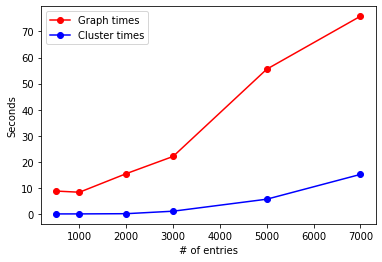

In [0]:
time_graph = [8.82,8.37,15.5,22.09,55.53,75.82]
time_clust = [0.058,0.064,0.144,1.10,5.70,15.20]

plt.plot(size, time_graph, 'or-', label='Graph')
plt.plot(size, time_clust, 'ob-', label='Cluster')
plt.legend()
plt.xlabel('# of entries')
plt.ylabel('Seconds')
plt.show()

####Score

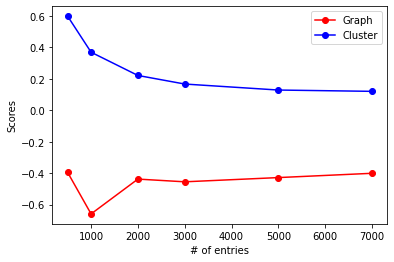

In [0]:
score_graph = [-0.3958,-0.6597,-0.438,-0.4553,-0.4284,-0.4011]
score_clust = [0.5987,0.3697,0.2217,0.1671,0.1289,0.1206]

plt.plot(size, score_graph, 'or-', label='Graph')
plt.plot(size, score_clust, 'ob-', label='Cluster')
plt.legend()
plt.xlabel('# of entries')
plt.ylabel('Scores')
plt.show()

####Connected Components

No handles with labels found to put in legend.

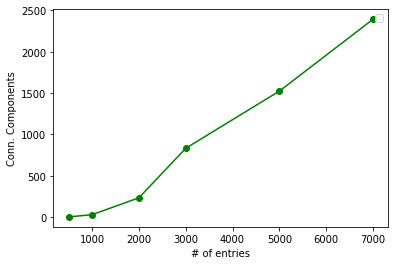

In [0]:
cc = [3,30,234,833,1525,2394]

plt.plot(size, cc, 'og-')
plt.legend()
plt.xlabel('# of entries')
plt.ylabel('Conn. Components')
plt.show()

##Advanced Cluster

#####PCA

In [0]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(clusters_df)
model.getK()

model.setOutputCol("pca_features")

x = model.transform(clusters_df).collect()

display(x)


In [0]:
from random import randint

####Plot Cluster

In [0]:
dim1 = []
dim2 = []
my_colors = []

myset = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']

for i in range(K):
  color = '#'
  for i in range(6):
    color = color+myset[randint(0,15)]
  colors.append(color)
  
for i in range(len(x)):
  dim1.append(x[i]['pca_features'][0])
  dim2.append(x[i]['pca_features'][1])
  my_colors.append(colors[x[i]['cluster']])
  
plt.scatter(dim1,dim2,c=my_colors)
